In [3]:
import copy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import MinMaxScaler
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['SimHei']

### 数据预处理

将时间特征表示为当前一天内的分钟数、周几(周一用1表示，周二用2表示...)、是否为节假日（是用1表示，调休用0.5表示，其他用0表示）、年份（2021用1表示，2022用2表示，2023用3表示）。    
2022年和2023年元宵节附近10来天电力负荷出现了很明显的下降，2021年在农历腊月十几电力负荷出现了明显的下降，持续时间和强度与2022和2023年年初类似，但却不是在元宵节期间，不知道为什么会明显下降。  
一年中不同时间负荷的变化受所在地区气候的影响比较大，可以用气象信息包含，不再加入月份特征。  
突发情况可由人工调节。  
将分类特征用单个数值表示，比较简便，但可能对模型的性能造成影响。感觉比较好的是用one-hot(太稀疏)或embedding。  
模型的预测结果作为参考，最终的预测还需要人工的参与、修正。

In [4]:
data = pd.read_csv('../data/gfdf_with_cloud_1.csv')

In [5]:
data

,Unnamed: 0,time,value,weather_status,temperature,humidity,wind_speed,wind_level,wind_direction_angle,wind_direction,pressure,visibility,precipitation,light,holiday
0,0,2021/1/1 0:00,3210.842464,1,'-8.6','41','0.5','0','359','鍖楅','977','9.7','0','0',1.0
1,1,2021/1/1 0:15,3104.507008,1,'-8.88','43.00','0.5','0','359','鍖楅','977','9.7','0','0',1.0
2,2,2021/1/1 0:30,3037.705984,1,'-9.16','45.00','0.5','0','359','鍖楅','977','9.7','0','0',1.0
3,3,2021/1/1 0:45,2960.176288,1,'-9.44','47.00','0.5','0','359','鍖楅','977','9.7','0','0',1.0
4,4,2021/1/1 1:00,2889.226528,3,'-9.7','49','0.7','0','335','瑗垮寳椋?,'976','8.6','0','0',1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75547,75547,2023/2/26 22:45,5649.941920,1,'5.85','64.75','1.6','17','250','瑗块','976','5.2','0','0',0.0
75548,75548,2023/2/26 23:00,5451.523744,1,'5.5','66','1','0','124','涓滃崡椋?,'976','4.6','0','0',0.0
75549,75549,2023/2/26 23:15,5246.500000,1,'5.15','67.25','1','0','124','涓滃崡椋?,'976','4.6','0','0',0.0
75550,75550,2023/2/26 23:30,5039.924704,1,'4.80','68.50','1','0','124','涓滃崡椋?,'976','4.6','0','0',0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            75552 non-null  int64  
 1   time                  75552 non-null  object 
 2   value                 75552 non-null  float64
 3   weather_status        75552 non-null  int64  
 4   temperature           75552 non-null  object 
 5   humidity              75552 non-null  object 
 6   wind_speed            75552 non-null  object 
 7   wind_level            75552 non-null  object 
 8   wind_direction_angle  75552 non-null  object 
 9   wind_direction        75552 non-null  object 
 10  pressure              75552 non-null  object 
 11  visibility            75552 non-null  object 
 12  precipitation         75552 non-null  object 
 13  light                 75552 non-null  object 
 14  holiday               75552 non-null  float64
dtypes: float64(2), int6

In [7]:
data['value'].sort_values()

33565      134.39680
60009      142.00000
60011      142.00000
60012      142.00000
60013      142.00000
            ...     
55836    10089.16566
55837    10089.32032
59105    10092.06246
59104    10095.52374
55838    10113.88000
Name: value, Length: 75552, dtype: float64

In [8]:
data['value'].sort_values()[:20]

33565     134.396800
60009     142.000000
60011     142.000000
60012     142.000000
60013     142.000000
60014     142.000000
60015     142.000000
60057     142.000000
60010     142.000000
2524     1142.851840
2525     1147.319296
2523     1151.860864
2516     1153.393504
2519     1153.741312
2517     1155.662752
2522     1156.089664
2514     1156.364224
2520     1156.569280
2521     1156.853824
2620     1157.596960
Name: value, dtype: float64

In [9]:
data['value'].sort_values()[-1000:]

53340     9410.317216
60924     9410.851552
56030     9411.538720
57830     9411.738400
57832     9411.755296
             ...     
55836    10089.165660
55837    10089.320320
59105    10092.062460
59104    10095.523740
55838    10113.880000
Name: value, Length: 1000, dtype: float64

电力负荷的最大值没发现异常，最小值发现了异常

电力负荷的数值存在9个100多的，为异常点，可能是发生了突发情况。为更好训练模型，需要对异常值进行处理。

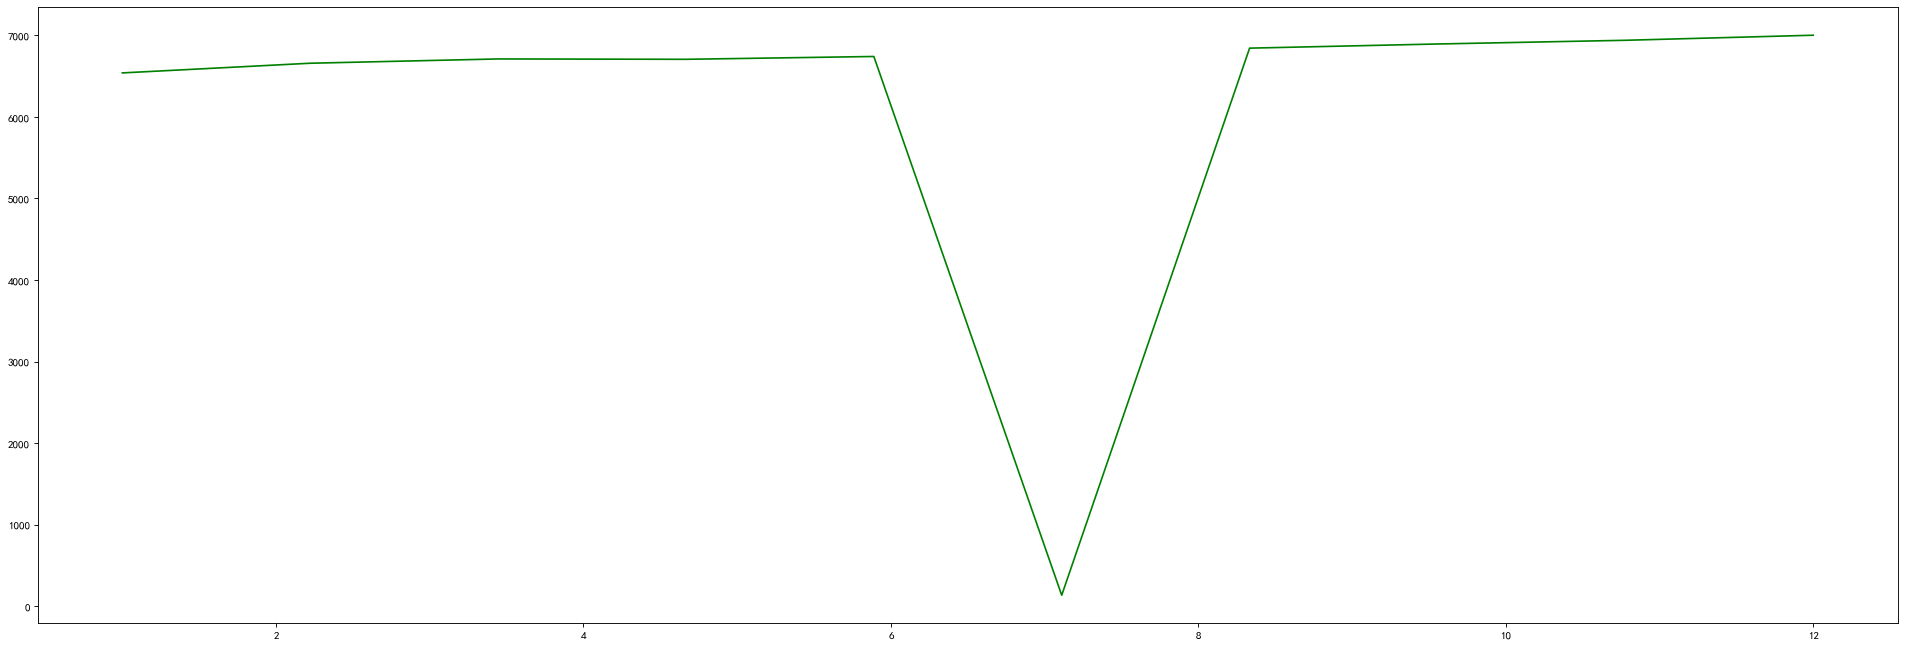

In [10]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 12, 10, endpoint=True)
C = np.array(data['value'][33560: 33570])
plt.plot(X, C, color='green')
plt.show()

对序号为33565这条数据，使用其前一个时刻和后一个时刻负荷的平均值代替其的负荷值

In [11]:
data.loc[33565, 'value'] = (data.loc[33564]['value'] + data.loc[33566]['value']) / 2

In [12]:
data.loc[33565]['value']

6791.646016

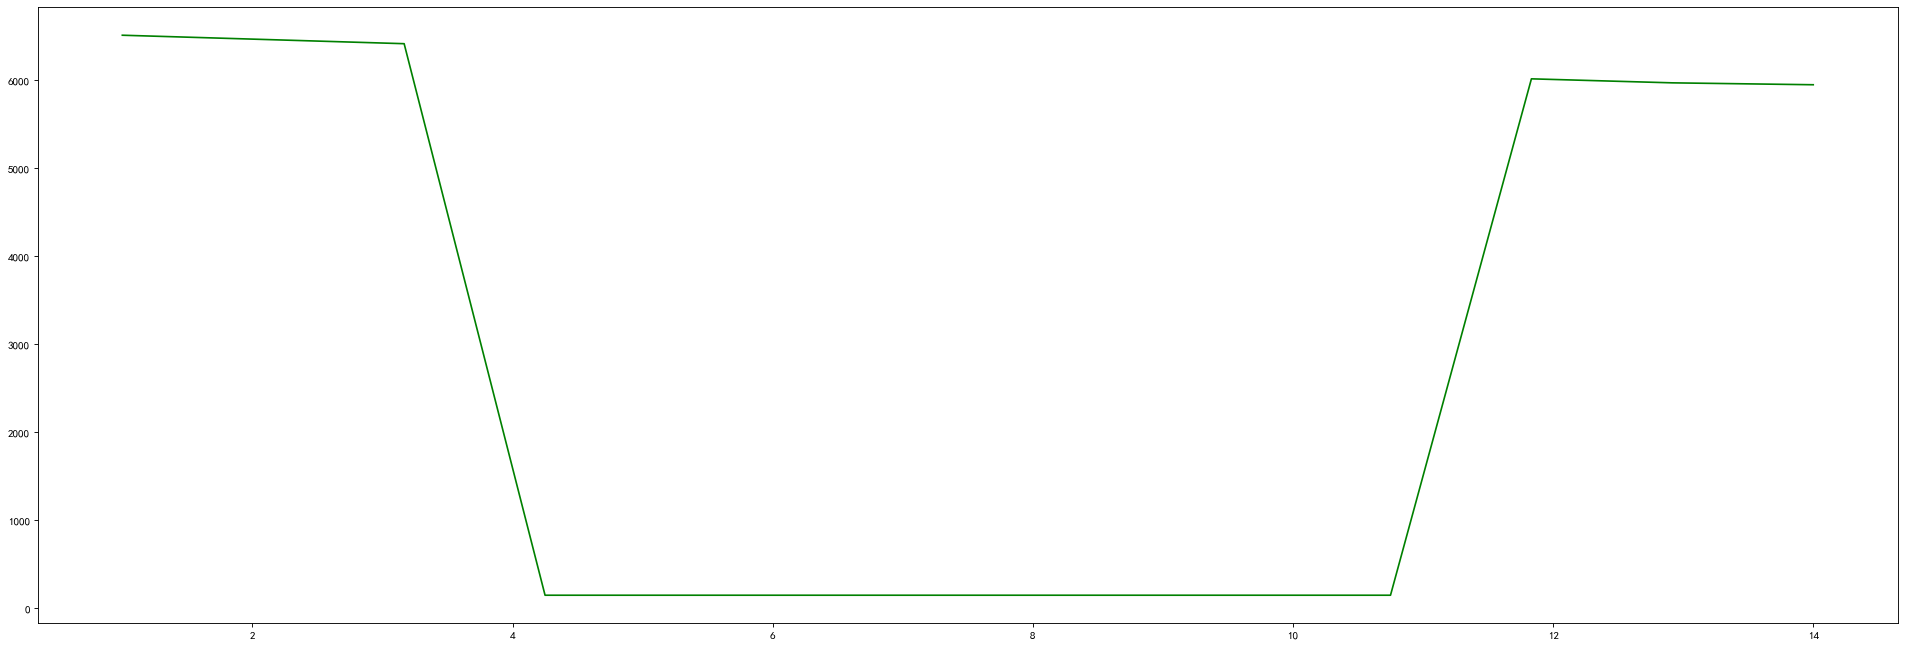

In [13]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 14, 13, endpoint=True)
C = np.array(data['value'][60006: 60019])
plt.plot(X, C, color='green')
plt.show()

对序号为60009到60015这7条数据，使用序号为60008和60016数据的负荷的平均值代替他们的负荷值

In [14]:
data.loc[60009: 60015, 'value'] = (data.loc[60008]['value'] + data.loc[60016]['value']) / 2

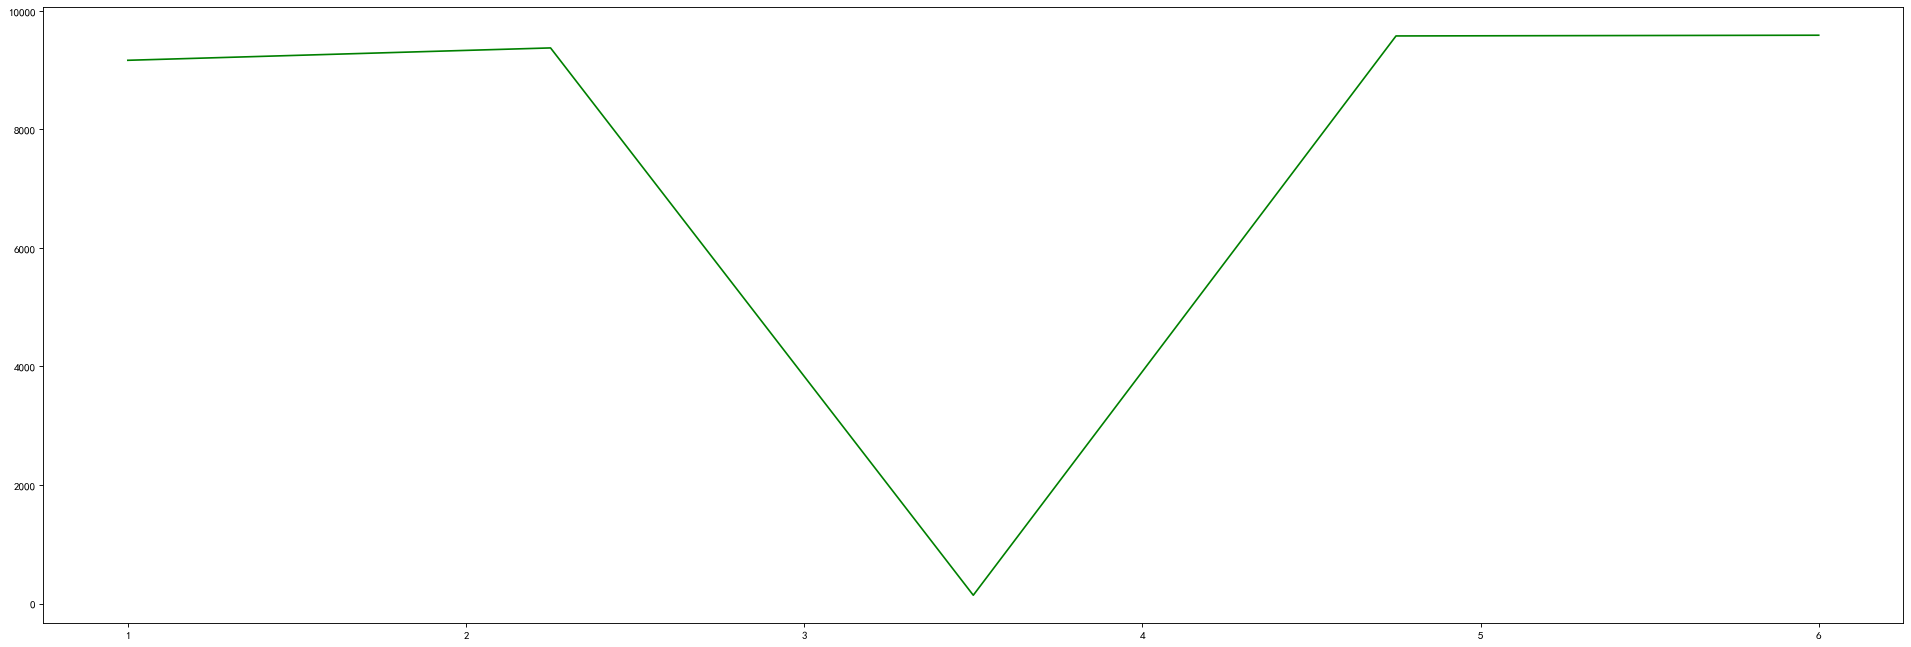

In [15]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 6, 5, endpoint=True)
C = np.array(data['value'][60055: 60060])
plt.plot(X, C, color='green')
plt.show()

对序号为60057这条数据，使用其前一个时刻和后一个时刻负荷的平均值代替其的负荷值

In [16]:
data.loc[60057, 'value'] = (data.loc[60056]['value'] + data.loc[60058]['value']) / 2

In [17]:
data.loc[60057, 'value']

9473.481759999999

将时间分成年、月、日、分钟数，并将一天内的分钟数作为一个特征。

In [18]:
list1 = [i.split('/') for i in data['time']]
list2 = [i[-1].split(' ') for i in list1]
list3 = [i[-1].split(':') for i in list2]
list4 = [int(i[0]) * 60 + int(i[1]) for i in list3]  # 分钟
minute = np.array(list4).reshape(len(data), 1)

生成星期特征

In [19]:
# 2021-1-1为周五
week = np.empty(len(data))
print(len(data)/(96*7))  # 有余数
print(len(data) % (96*7) // 96)  # 剩余的天数
for i in range(len(data)//(96*7)):
    m = i * 96 * 7
    week[m:m+96] = 5
    week[m+96: m+96*2] = 6
    week[m+96*2: m+96*3] = 7
    week[m+96*3: m+96*4] = 1
    week[m+96*4: m+96*5] = 2
    week[m+96*5: m+96*6] = 3
    week[m+96*6: m+96*7] = 4
week[m+96*7: m+96*8] = 5
week[m+96*8: m+96*9] = 6
week[m+96*9: m+96*10] = 7
week = week.reshape(len(data), 1)

112.42857142857143
3


In [20]:
week.dtype

dtype('float64')

生成年份特征

In [21]:
year = np.empty(len(data))
year[: 96*365] = 1
year[96*365: 96*365*2] = 2
year[96*365*2: ] = 3
year = year.reshape(len(data), 1)

In [22]:
year.dtype

dtype('float64')

将新特征与原dataframe拼接起来，并删去多余的列

In [23]:
array1 = np.concatenate((minute,week,year), axis=1)

In [24]:
array1.shape

(75552, 3)

In [25]:
df_1 = pd.DataFrame(array1, columns=['minute', 'week', 'year'])

In [26]:
new_data = pd.concat((data, df_1), axis=1).drop(['Unnamed: 0', 'wind_direction', 'time'], axis=1)

In [27]:
new_data

,value,weather_status,temperature,humidity,wind_speed,wind_level,wind_direction_angle,pressure,visibility,precipitation,light,holiday,minute,week,year
0,3210.842464,1,'-8.6','41','0.5','0','359','977','9.7','0','0',1.0,0.0,5.0,1.0
1,3104.507008,1,'-8.88','43.00','0.5','0','359','977','9.7','0','0',1.0,15.0,5.0,1.0
2,3037.705984,1,'-9.16','45.00','0.5','0','359','977','9.7','0','0',1.0,30.0,5.0,1.0
3,2960.176288,1,'-9.44','47.00','0.5','0','359','977','9.7','0','0',1.0,45.0,5.0,1.0
4,2889.226528,3,'-9.7','49','0.7','0','335','976','8.6','0','0',1.0,60.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75547,5649.941920,1,'5.85','64.75','1.6','17','250','976','5.2','0','0',0.0,1365.0,7.0,3.0
75548,5451.523744,1,'5.5','66','1','0','124','976','4.6','0','0',0.0,1380.0,7.0,3.0
75549,5246.500000,1,'5.15','67.25','1','0','124','976','4.6','0','0',0.0,1395.0,7.0,3.0
75550,5039.924704,1,'4.80','68.50','1','0','124','976','4.6','0','0',0.0,1410.0,7.0,3.0


In [28]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float64
 1   weather_status        75552 non-null  int64  
 2   temperature           75552 non-null  object 
 3   humidity              75552 non-null  object 
 4   wind_speed            75552 non-null  object 
 5   wind_level            75552 non-null  object 
 6   wind_direction_angle  75552 non-null  object 
 7   pressure              75552 non-null  object 
 8   visibility            75552 non-null  object 
 9   precipitation         75552 non-null  object 
 10  light                 75552 non-null  object 
 11  holiday               75552 non-null  float64
 12  minute                75552 non-null  float64
 13  week                  75552 non-null  float64
 14  year                  75552 non-null  float64
dtypes: float64(5), int6

将object类型数据两边的引号去掉，然后转为数值类型

In [29]:
df_2 = new_data[['temperature', 'humidity', 'wind_speed', 'wind_level', 'wind_direction_angle', 'pressure', 'visibility', 'precipitation', 'light']]

In [30]:
df_2

,temperature,humidity,wind_speed,wind_level,wind_direction_angle,pressure,visibility,precipitation,light
0,'-8.6','41','0.5','0','359','977','9.7','0','0'
1,'-8.88','43.00','0.5','0','359','977','9.7','0','0'
2,'-9.16','45.00','0.5','0','359','977','9.7','0','0'
3,'-9.44','47.00','0.5','0','359','977','9.7','0','0'
4,'-9.7','49','0.7','0','335','976','8.6','0','0'
...,...,...,...,...,...,...,...,...,...
75547,'5.85','64.75','1.6','17','250','976','5.2','0','0'
75548,'5.5','66','1','0','124','976','4.6','0','0'
75549,'5.15','67.25','1','0','124','976','4.6','0','0'
75550,'4.80','68.50','1','0','124','976','4.6','0','0'


In [31]:
array2 = np.array(df_2)

In [32]:
for i in range(9):
    a = [j[1: -1] for j in array2[:, i]]
    a = pd.to_numeric(a)  # 也可使用float()
    array2[:, i] = a

In [33]:
array2 = array2.astype(dtype=np.float32)

新的dataframe

In [34]:
new_data[['temperature', 'humidity', 'wind_speed', 'wind_level', 'wind_direction_angle', 'pressure', 'visibility', 'precipitation', 'light']] = array2

In [35]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float64
 1   weather_status        75552 non-null  int64  
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_level            75552 non-null  float32
 6   wind_direction_angle  75552 non-null  float32
 7   pressure              75552 non-null  float32
 8   visibility            75552 non-null  float32
 9   precipitation         75552 non-null  float32
 10  light                 75552 non-null  float32
 11  holiday               75552 non-null  float64
 12  minute                75552 non-null  float64
 13  week                  75552 non-null  float64
 14  year                  75552 non-null  float64
dtypes: float32(9), floa

In [36]:
new_data = new_data.astype(np.float32)

In [37]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float32
 1   weather_status        75552 non-null  float32
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_level            75552 non-null  float32
 6   wind_direction_angle  75552 non-null  float32
 7   pressure              75552 non-null  float32
 8   visibility            75552 non-null  float32
 9   precipitation         75552 non-null  float32
 10  light                 75552 non-null  float32
 11  holiday               75552 non-null  float32
 12  minute                75552 non-null  float32
 13  week                  75552 non-null  float32
 14  year                  75552 non-null  float32
dtypes: float32(15)
memo

查看气象特征的数值分布，看看有没有异常值

In [38]:
new_data['weather_status'].sort_values()  # 天气状态

0         1.0
40732     1.0
40733     1.0
40734     1.0
40735     1.0
         ... 
7113     23.0
7112     23.0
7111     23.0
7119     23.0
7115     23.0
Name: weather_status, Length: 75552, dtype: float32

In [39]:
new_data['weather_status'].value_counts()  # 天气状态

weather_status
1.0     35216
2.0     15152
3.0     14548
11.0     3272
7.0      2776
19.0     2292
21.0      808
16.0      556
20.0      436
8.0       256
12.0      136
22.0       44
9.0        36
23.0       20
15.0        4
Name: count, dtype: int64

In [40]:
new_data['temperature'].sort_values()  # 温度

604     -14.600000
605     -14.570000
603     -14.540000
606     -14.540000
607     -14.510000
           ...    
51811    40.759998
51810    40.840000
51807    40.849998
51809    40.919998
51808    41.000000
Name: temperature, Length: 75552, dtype: float32

In [41]:
new_data['humidity'].sort_values()  # 湿度

12099      6.0
12100      6.0
12092      6.0
12098      6.0
12097      6.0
         ...  
53594    100.0
53883    100.0
53882    100.0
54265    100.0
53472    100.0
Name: humidity, Length: 75552, dtype: float32

In [42]:
new_data['wind_speed'].sort_values()  # 风速

31805     0.0
69607     0.0
69606     0.0
69605     0.0
69604     0.0
         ... 
589       9.2
592      13.3
595      13.3
594      13.3
593      13.3
Name: wind_speed, Length: 75552, dtype: float32

In [43]:
new_data['wind_level'].sort_values()  # 风力等级

0         0.0
36415     0.0
36414     0.0
36413     0.0
36412     0.0
         ... 
28779    17.0
28784    17.0
28785    17.0
28787    17.0
37775    17.0
Name: wind_level, Length: 75552, dtype: float32

In [44]:
new_data['wind_level'].value_counts()  # 风力等级

wind_level
17.0    29791
0.0     23249
1.0     22296
2.0       212
3.0         4
Name: count, dtype: int64

In [45]:
new_data['wind_direction_angle'].sort_values()  # 风向角

29254      0.0
25912      0.0
25913      0.0
25914      0.0
25915      0.0
         ...  
56958    360.0
56959    360.0
59947    360.0
39196    360.0
59055    360.0
Name: wind_direction_angle, Length: 75552, dtype: float32

In [46]:
new_data['pressure'].sort_values()  # 压力

43011     857.0
43010     857.0
43009     857.0
43008     857.0
42995     861.0
          ...  
42999    1008.0
44308    1018.0
44309    1018.0
44310    1018.0
44311    1018.0
Name: pressure, Length: 75552, dtype: float32

In [47]:
new_data['visibility'].sort_values()  # 可见度

26222     0.1
26223     0.1
26229     0.1
26221     0.1
26231     0.1
         ... 
16553    30.0
16552    30.0
16551    30.0
16560    30.0
58950    30.0
Name: visibility, Length: 75552, dtype: float32

In [48]:
new_data['visibility'].value_counts()  # 可见度

visibility
30.0    9720
6.4     1992
14.4    1492
12.2     588
5.4      512
        ... 
0.6       16
0.4       16
0.3       12
0.1        8
0.5        4
Name: count, Length: 299, dtype: int64

In [49]:
new_data['precipitation'].sort_values()  # 降水

0         0.000000
49750     0.000000
49749     0.000000
49748     0.000000
49747     0.000000
           ...    
53875    15.200000
53870    34.599998
53869    34.599998
53868    34.599998
53871    34.599998
Name: precipitation, Length: 75552, dtype: float32

In [50]:
new_data['light'].sort_values()  # 光照强度

0          0.000000
40226      0.000000
40227      0.000000
40228      0.000000
40229      0.000000
            ...    
14163    998.409973
49392    999.203369
49394    999.203369
49395    999.203369
49393    999.203369
Name: light, Length: 75552, dtype: float32

气象数据未发现异常值。

风速和风力等级重复了，并且这个数据集里风力等级只有0，1，2，3，17这5种取值，所以删去风力等级(wind_level)列。

In [51]:
new_data = new_data.drop('wind_level', axis=1)

In [52]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 75552 non-null  float32
 1   weather_status        75552 non-null  float32
 2   temperature           75552 non-null  float32
 3   humidity              75552 non-null  float32
 4   wind_speed            75552 non-null  float32
 5   wind_direction_angle  75552 non-null  float32
 6   pressure              75552 non-null  float32
 7   visibility            75552 non-null  float32
 8   precipitation         75552 non-null  float32
 9   light                 75552 non-null  float32
 10  holiday               75552 non-null  float32
 11  minute                75552 non-null  float32
 12  week                  75552 non-null  float32
 13  year                  75552 non-null  float32
dtypes: float32(14)
memory usage: 4.0 MB


将new_data保存起来

In [53]:
new_data.to_csv('new_data.csv')

划分训练集和测试集，2021年和2022年的数据作为训练集，2023年的数据作为测试集

In [54]:
# 可以之后再将2021、2022的数据和2023的部分数据作为训练

In [55]:
train = new_data.loc[:70079]
test = new_data.loc[70080:]

In [56]:
print(len(train))
print(len(test))

70080
5472


对训练集数据归一化

In [57]:
scaler = MinMaxScaler()
scaler = scaler.fit(train)  # fit，在这里本质是生成min(x)和max(x)
train_result = scaler.transform(train)  # 结果为ndarray类型

In [58]:
scaler

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [59]:
train_result.shape

(70080, 14)

生成训练数据

In [60]:
#  将预测时刻的气象数据也作为输入，为了保证输入序列的特征数一致，将预测时刻输入的负荷设为1
#  可以做个比较，有预测时刻的气象信息与没有预测时刻的气象信息。感觉有预测时刻的气象信息作为输入，模型预测准确性会受到天气预报准确性的影响。
#  生成的样本起始时刻依次相差15分钟
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw+1):
        train_seq = copy.deepcopy(input_data[i:i+tw])
        train_seq[96:tw, 0] = 1
        train_label = input_data[i+96:i+tw, 0]
        inout_seq.append((torch.tensor(train_seq) ,torch.tensor(train_label)))
    return inout_seq

In [61]:
train_inout_seq = create_inout_sequences(train_result, 192)

In [62]:
len(train_inout_seq)

69889

训练样本的数量为69889，每个训练样本包括特征和标签，其中特征为前96个时刻和后96个时刻的气象数据和负荷值（后96个时刻的负荷值用1代替，只是占个位置，保证输入序列的特征数一致，没有实际含义），标签为后96个时刻的负荷值。

使用前24小时和未来24小时的数据预测未来24小时的负荷

设置批量大小为96

In [63]:
trainloader = torch.utils.data.DataLoader(train_inout_seq, batch_size=96, shuffle=True)

In [64]:
len(trainloader)

729

In [65]:
for i ,j in trainloader:
    print(i.shape)
    print(j.shape)

torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([96, 192, 14])
torch.Size([96, 96])
torch.Size([9

### 建立LSTM模型并训练

In [66]:
class LstmNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.LSTM(14, 60, 1, batch_first=True)  # 这个lstm的输入为15个神经元，隐藏层的输出为50个神经元，每个训练样本一次训练这个lstm被重复执行了49次，
        self.layer2 = nn.Linear(60, 1)  # 或者形象地说这个lstm结构在时间上的长度为49。
        
    def forward(self, x):
        y1, _ = self.layer1(x)
        y1 = y1[:, -96:, :]
        y2 = self.layer2(y1)
        return y2.reshape(-1, 96)

In [67]:
49*1*15; 15*50; 49*1*50; 49*50; 50*1; 49*1  # 批量大小为1
49*64*15; 15*50; 49*64*50; 50*1; 49*64*1  # 批量大小为64
192*1*15; 15*50; 192*1*50; 96*1*50; 96*50; 50*1; 96*1

96

In [68]:
96*192*15
15*50
96*192*50
96*96*50
50*1
96*96*1
96*96  # 批量大小为96，batch_first=True

9216

In [69]:
lstmnet = LstmNet()

In [70]:
lr = 0.001
opt = optim.Adam(lstmnet.parameters(), lr=lr)

In [71]:
loss_function = nn.MSELoss()  # 方差/平均平方误差

In [72]:
# 刚开始使用学习率为0.01训练，损失下降到0.001左右时，开始波动比较大，损失没有什么下降，然后使用学习率为0.003训练，然后使用学习率0.001训练。
# 得到的损失最小值为0.0003左右。

In [73]:
epochs = 1
for epoch in range(epochs):
    i = 0
    all_loss = 0
    for xb, yb in trainloader:
        y = lstmnet(xb)
        loss = loss_function(y, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        i += 1
        all_loss += loss.data
        if i%10 == 0:
            print(loss.data)
    print('损失:')
    print(all_loss / len(trainloader))

tensor(0.0544)
tensor(0.0347)
tensor(0.0302)
tensor(0.0304)
tensor(0.0282)
tensor(0.0198)
tensor(0.0224)
tensor(0.0238)
tensor(0.0181)
tensor(0.0182)
tensor(0.0177)
tensor(0.0177)
tensor(0.0179)
tensor(0.0214)
tensor(0.0194)
tensor(0.0201)
tensor(0.0131)
tensor(0.0166)
tensor(0.0162)
tensor(0.0213)
tensor(0.0169)
tensor(0.0170)
tensor(0.0173)
tensor(0.0161)
tensor(0.0144)
tensor(0.0131)
tensor(0.0182)
tensor(0.0143)
tensor(0.0149)
tensor(0.0135)
tensor(0.0166)
tensor(0.0142)
tensor(0.0162)
tensor(0.0142)
tensor(0.0096)
tensor(0.0166)
tensor(0.0187)
tensor(0.0112)
tensor(0.0133)
tensor(0.0129)
tensor(0.0164)
tensor(0.0135)
tensor(0.0120)
tensor(0.0115)
tensor(0.0181)
tensor(0.0153)
tensor(0.0108)
tensor(0.0132)
tensor(0.0172)
tensor(0.0137)
tensor(0.0091)
tensor(0.0129)
tensor(0.0148)
tensor(0.0114)
tensor(0.0125)
tensor(0.0121)
tensor(0.0087)
tensor(0.0131)
tensor(0.0112)
tensor(0.0098)
tensor(0.0096)
tensor(0.0111)
tensor(0.0112)
tensor(0.0112)
tensor(0.0134)
tensor(0.0111)
tensor(0.0

### 预测

解决v_max v_min 未定义问题

In [74]:
v_max = max(train['value'])
v_min = min(train['value'])

In [75]:
(300 / (v_max - v_min)) ** 2

0.0011182993634812012

In [76]:
(100 / (v_max - v_min)) ** 2

0.00012425548483124458

In [77]:
test_result = scaler.transform(test)

生成测试数据

In [78]:
test_seq = create_inout_sequences(test_result, 192)

In [79]:
len(test_seq)

5281

预测测试集里的某一样本

In [80]:
v_max = max(train['value'])
v_min = min(train['value'])

In [81]:
pred = lstmnet(test_seq[1000][0].reshape(1, 192, 14))

In [82]:
pred

tensor([[0.6392, 0.6440, 0.6442, 0.6420, 0.6429, 0.6412, 0.6391, 0.6377, 0.6423,
         0.6482, 0.6533, 0.6581, 0.6603, 0.6621, 0.6654, 0.6697, 0.6744, 0.6749,
         0.6760, 0.6777, 0.6756, 0.6758, 0.6764, 0.6767, 0.6675, 0.6655, 0.6650,
         0.6645, 0.6623, 0.6564, 0.6519, 0.6485, 0.6449, 0.6429, 0.6413, 0.6397,
         0.6325, 0.6294, 0.6258, 0.6214, 0.6171, 0.6120, 0.6066, 0.6011, 0.5946,
         0.5890, 0.5836, 0.5784, 0.5743, 0.5717, 0.5678, 0.5629, 0.5571, 0.5513,
         0.5456, 0.5400, 0.4787, 0.4504, 0.4335, 0.4218, 0.4119, 0.4041, 0.3968,
         0.3897, 0.3830, 0.3762, 0.3693, 0.3624, 0.3544, 0.3486, 0.3441, 0.3405,
         0.3453, 0.3460, 0.3480, 0.3522, 0.3586, 0.3668, 0.3768, 0.3886, 0.4015,
         0.4165, 0.4340, 0.4544, 0.4747, 0.4991, 0.5255, 0.5527, 0.5834, 0.6110,
         0.6355, 0.6564, 0.6795, 0.6949, 0.7044, 0.7087]],
       grad_fn=<ViewBackward0>)

In [83]:
test_seq[1000][1]

tensor([0.7438, 0.7479, 0.7525, 0.7546, 0.7566, 0.7574, 0.7340, 0.6965, 0.6058,
        0.5454, 0.5497, 0.5459, 0.5520, 0.5751, 0.6282, 0.6901, 0.7053, 0.7180,
        0.7231, 0.7245, 0.7289, 0.7326, 0.7373, 0.7423, 0.7494, 0.7569, 0.7621,
        0.7644, 0.7519, 0.7399, 0.6878, 0.6572, 0.6601, 0.6830, 0.7160, 0.7424,
        0.7512, 0.7533, 0.7480, 0.7448, 0.7371, 0.7361, 0.7352, 0.7323, 0.7238,
        0.7156, 0.7050, 0.6902, 0.6684, 0.6499, 0.6277, 0.6015, 0.5719, 0.5347,
        0.5085, 0.4784, 0.4558, 0.4380, 0.4276, 0.4187, 0.4123, 0.4054, 0.4012,
        0.3985, 0.3931, 0.3883, 0.3853, 0.3809, 0.3779, 0.3724, 0.3692, 0.3671,
        0.3663, 0.3658, 0.3635, 0.3650, 0.3642, 0.3646, 0.3648, 0.3666, 0.3673,
        0.3725, 0.3763, 0.3835, 0.3991, 0.4210, 0.4496, 0.4904, 0.5608, 0.6409,
        0.6738, 0.6920, 0.7003, 0.7079, 0.7155, 0.7194])

In [84]:
true_label = test_seq[1000][1] * (v_max - v_min) + v_min
true_label = true_label.detach().numpy()

In [85]:
true_pred = pred * (v_max - v_min) + v_min
true_pred = true_pred.reshape(96)
true_pred = true_pred.detach().numpy()

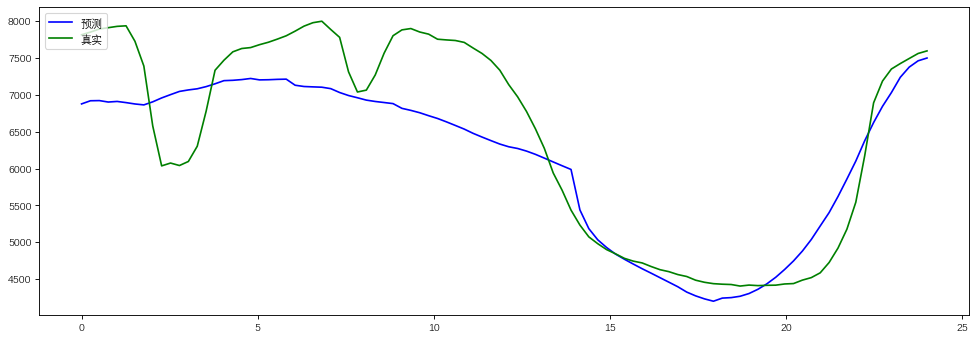

In [86]:
plt.rc('font',family='DengXian')
plt.figure(figsize=(15, 5), dpi=80)

X = np.linspace(0, 24, 96, endpoint=True)
C,S = true_pred, true_label
plt.plot(X, C, color='blue', label='预测')
plt.plot(X, S, color='green', label='真实')
plt.legend(loc='upper left')
plt.show()

采用绝对百分比误差（APE）对模型的预测准确度进行评价

单个样本的APE：|y预测 - y真实| ÷ y真实 × 100%

In [87]:
def APE_list(test_seq):  # 预测的每个24小时的平均APE组成的列表
    list1 = []
    for i in test_seq:
        pred = lstmnet(i[0].reshape(1, 192, 14))
        true_label = i[1] * (v_max - v_min) + v_min
        true_label = true_label.detach().numpy()
        true_pred = pred * (v_max - v_min) + v_min
        true_pred = true_pred.reshape(96)
        true_pred = true_pred.detach().numpy()
        num = sum(abs(true_pred - true_label) / true_label) / 96
        list1.append(num)

    return list1
#max(list1), min(list1)，list1.index()

在训练数据上的APE(随机选取5000个样本)

In [88]:
train_samples = random.sample(train_inout_seq, 5000)
list1 = APE_list(train_samples)
str(sum(list1) / len(list1) * 100) + '%'

'14.898702260749754%'

In [89]:
print("2.2772615524194593%")
print("2.206285492008685%")

2.2772615524194593%
2.206285492008685%


训练数据5000个样本的APE分布的箱线图

<Axes: >

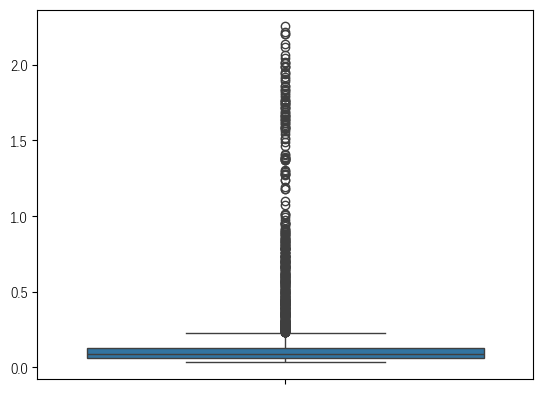

In [90]:
sns.boxplot(data=list1)

(0.0, 0.1)

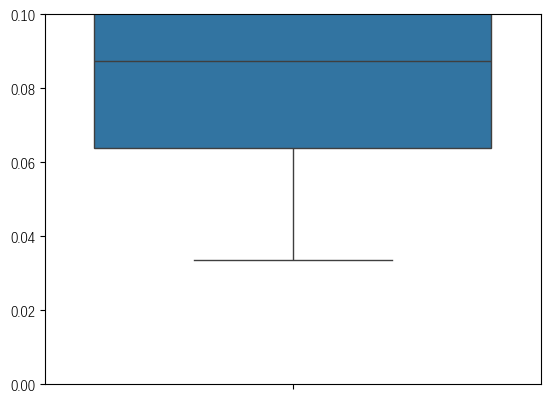

In [91]:
sns.boxplot(data=list1)
plt.ylim(0, 0.1)

在测试数据上的APE

In [92]:
list2 = APE_list(test_seq)
str(sum(list2) / len(list2) * 100) + '%'

'44.98145177531002%'

In [93]:
# 12.82968216754979%
# 11.554603512965041%
# 10.827513699236222%  保存了模型参数
# 12.067778039869548%
# 11.134349473801382%
# 12.187801521781639%
# 13.075773991825642%
# 11.319367309684035%
# 12.772845299314422%
# 12.93004775791501%
# 12.542951042622278%

测试数据的APE分布的箱线图

<Axes: >

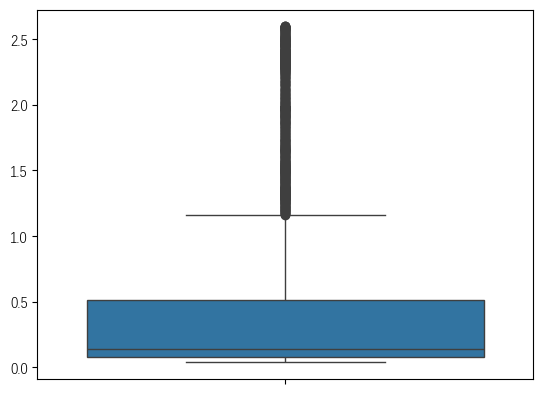

In [94]:
sns.boxplot(data=list2)

(0.0, 0.4)

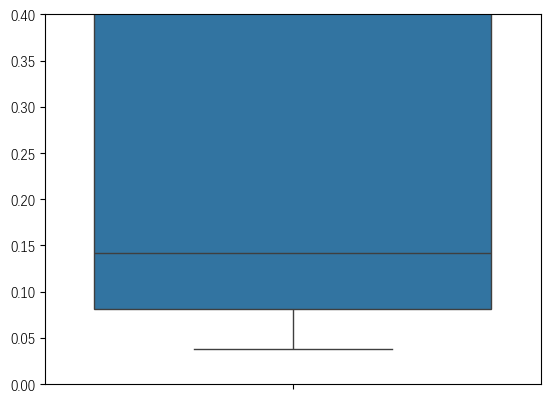

In [95]:
sns.boxplot(data=list2)
plt.ylim(0, 0.4)

In [96]:
min(list2)

0.037486181985210955

In [97]:
max(list2)

2.5983755898972354

In [98]:
torch.save(lstmnet.state_dict(), 'lstmnet_2_5_1.pt')

之后可和全连接神经网络的性能做个对比